## Simulation

In [ ]:
import sqlite3
import simpy
import Dijkstra

# Klasse Produkt definieren - Attribute siehe DB
class Produkt:
    def __init__(self, id, bezeichnung, dlz_plan, losgroesse, bestand_rtl, bestand_ftl):
        self.id = id
        self.bezeichnung = bezeichnung
        self.dlz_plan = dlz_plan
        self.losgroesse = losgroesse
        self.bestand_rtl = bestand_rtl
        self.bestand_ftl = bestand_ftl        

# Überschreiben der __repr__ Methode, damit die Objekte als Klartext beim Printen angezeigt werden
    def __repr__(self):
        return (f"Produkt(id={self.id}, bezeichnung='{self.bezeichnung}', dlz_plan={self.dlz_plan}, "
                f"losgroesse={self.losgroesse}, bestand_rtl={self.bestand_rtl}, bestand_ftl={self.bestand_ftl})")

# Klasse Auftrag definieren - Attribute siehe DB
class Auftrag:
    def __init__(self, charge, id, menge):
        self.charge = charge
        self.id = id
        self.arbeitsplan = []
        self.menge = menge
    
    # Überschreiben der __repr__ Methode, damit die Objekte als Klartext beim Printen angezeigt werden
    def __repr__(self):
        return f"Auftrag(charge={self.charge}, id={self.id}, arbeitsplan={self.arbeitsplan})"

# Klasse FFZ definieren - Attribute siehe DB
class FFZ:
    def __init__(self, id, speed, akkulaufzeit):
        self.id = id
        self.speed = speed
        self.akkulaufzeit = akkulaufzeit
        self.akkustand = akkulaufzeit
        self.curr_location = "g"
        self.curr_transport = None
        self.queue = []
    
    # Überschreiben der __repr__ Methode, damit die Objekte als Klartext beim Printen angezeigt werden
    def __repr__(self):
        return f"Auftrag(id={self.id})"
    
# Klasse Factory definieren
class Factory:
    def __init__(self, env, db_path):
        self.env = env # Simulationsumgebung
        self.db_path = db_path # Pfad zur Datenbank
        self.db() 
        self.lade_produkte()
        self.lade_ffz()
        self.saegen_queue = []
        self.saegen_status = "v"
        # v - verfügbar, b - belegt, d - defekt
        self.drehen_queue = []
        self.drehen_1_status = "v"
        self.drehen_2_status = "v"
        self.pruefen_queue = []
        self.pruefen_status = "v"
        self.transport_queue = []
        env.process(self.auftragsfreigabe(env))
        env.process(self.absatz(env))
        # Dijkstra
        self.graph = Dijkstra.graph([
        ("a", "b", 11), ("b", "a", 11),
        ("a", "c", 15), ("c", "a", 15),
        ("a", "d", 16), ("d", "a", 16),
        ("b", "c", 6), ("c", "b", 6),
        ("b", "d", 5), ("d", "b", 5),
        ("c", "g", 12), ("g", "c", 12),
        ("d", "e", 17), ("e", "d", 17),
        ("g", "e", 6), ("e", "g", 6),
        ("e", "f", 14), ("f", "e", 14)
        ])

    # DB Verbindung herstellen
    def db(self):
        self.conn = sqlite3.connect(self.db_path)
        self.cursor = self.conn.cursor()

    # Erstelle Produkt Objekte auf Basis der Produktstammdaten siehe db
    def lade_produkte(self):
        self.produkte = []

        # Produkte aus der Tabelle produktstammdaten abrufen
        self.cursor.execute('SELECT * FROM produktstammdaten')
        rows = self.cursor.fetchall()

        # Für jede Zeile ein Produkt-Objekt erstellen
        for row in rows:
            produkt = Produkt(id=row[0], bezeichnung=row[1], dlz_plan=row[2], losgroesse=row[3], bestand_rtl=row[4], bestand_ftl=row[5])
            self.produkte.append(produkt)
            # Name des Objekts entspricht der Bezeichnung
            globals()[produkt.bezeichnung] = produkt

    def lade_ffz(self):
        self.ffzs = []

        self.cursor.execute('SELECT * FROM ffz')
        rows = self.cursor.fetchall()

        for row in rows:
            ffz = FFZ(id=row[0], speed=row[1], akkulaufzeit=row[2])
            self.ffzs.append(ffz)    

    # Finde Source und Destination des Transports
    def find_source_destination(self, arbeitsschritt, folgeschritt):
        # Dictionary mit den Standorten der Arbeitsstationen
        location_map = {
            'RTL': 'a',  # RTL an Standort A
            'SAE': 'b',  # Sägen an Standort B
            'DRH': 'c',  # Drehen an Standort C
            'FRA': 'd',  # Fräsen an Standort D
            'QPR': 'e',  # Prüfen an Standort D
            'FTL': 'f',  # Fertigteillager an Standort E
        }

        # Bestimme den Standort für den aktuellen Arbeitsschritt
        if arbeitsschritt is not None:
            source = location_map.get(arbeitsschritt[0])
        else: 
            source = location_map.get('RTL')

        if folgeschritt is not None:
            destination = location_map.get(folgeschritt[0])
        else:
            destination = location_map.get('FTL')

        return source, destination


    # Einfachster Fall Bestellbestands-Verfahren - Freigabe neuer Aufträge bei Unterschreitung der Bestellbestands
    def auftragsfreigabe(self, env):
        self.auftraege = []
        
        while True: # Freigabe Prüflauf läuft kontinuierlich
            for produkt in self.produkte:
                # Berechne die Summe der Mengen aller Aufträge für das Produkt (Lagerbestand + Summe offene Aufträge)
                offene_auftragsmenge = sum(auftrag.menge for auftrag in self.auftraege if auftrag.id == produkt.id)
                
                while (produkt.bestand_ftl + offene_auftragsmenge) < 2200:
                    # Auftrag in die Datenbank einfügen
                    self.cursor.execute('INSERT INTO auftraege (id, stueckzahl) VALUES (?, ?)', (produkt.id, produkt.losgroesse))

                    # Abrufen der Charge für den letzten eingefügten Auftrag
                    self.cursor.execute('SELECT charge FROM auftraege ORDER BY charge DESC LIMIT 1')
                    charge = self.cursor.fetchone()[0]  

                    # Erstellen eines Auftrag-Objekts
                    auftrag = Auftrag(charge=charge, id=produkt.id, menge=produkt.losgroesse)
                    
                    # Suche nach den Arbeitsschritten
                    self.cursor.execute('SELECT bmg, r_plan, t_plan, nr FROM arbeitsplaene WHERE id=? ORDER BY nr ASC', (produkt.id,))
                    rows = self.cursor.fetchall()  
                    
                    # Alle Arbeitsplan-Einträge zum Auftrag hinzufügen
                    for row in rows:
                        auftrag.arbeitsplan.append(row) 

                    # Speichern des Auftrag-Objekts in der Liste
                    self.auftraege.append(auftrag)
                  
                    # Auftrag freigeben und als Prozess starten
                    env.process(self.produktion(auftrag, produkt,env))

                    # Commit
                    self.conn.commit()

                    # Aktualisiere die offene Auftragsmenge für die nächste Schleife
                    offene_auftragsmenge = sum(auftrag.menge for auftrag in self.auftraege if auftrag.id == produkt.id)

                    yield env.timeout(0)
            yield env.timeout(1)         
    
    # Produktionsfunktion zum Durchlauf aller Arbeitsschritte 
    def produktion(self, auftrag, produkt, env):
        """Führt die Produktionsschritte für einen gegebenen Auftrag durch.
        Args:
        auftrag: Das Auftrag-Objekt, das die Arbeitspläne enthält.
        produkt: Das Produkt, das bearbeitet wird.
        env: Die SimPy-Umgebung, die die Simulation verwaltet.
        """
        workstations = {
            'SAE': self.saegen,
            'DRH': self.drehen,
            'QPR': self.pruefen,
        }

        # Auftragsfreigabe in DB protokollieren 

        # Eintrag in DB zur Protokollierung des Lagereingangs
        freigabe = env.now
        self.cursor.execute('INSERT INTO FLF (ankunft, charge, bmg) VALUES (?, ?, ?)', 
                          (freigabe, auftrag.charge, 'RTL'))
        self.conn.commit()

        for i, arbeitsschritt in enumerate(auftrag.arbeitsplan):
            # Transport aus RTL für 1. Arbeitsschritt
            if arbeitsschritt == auftrag.arbeitsplan[0]:
                # Bestimme Source und Destination
                source, destination = self.find_source_destination(None, arbeitsschritt)
                # Transport
                yield env.process(self.transport(auftrag, source, destination, arbeitsschritt, env))
                ankunft = env.now
            else: # Ankunft aller anderen Aufträge
                ankunft = env.now

            # Start Bearbeitungsprozess            
            yield env.process(workstations.get(arbeitsschritt[0])(auftrag, arbeitsschritt, env))

            # Nächster Arbeitsschritt (falls vorhanden)
            folgeschritt = auftrag.arbeitsplan[i + 1] if i + 1 < len(auftrag.arbeitsplan) else None
  
            # Bestimme Source und Destination
            source, destination = self.find_source_destination(arbeitsschritt, folgeschritt)

            # Transport 
            yield env.process(self.transport(auftrag,source, destination, arbeitsschritt, env))

            # Einträge in DB pflegen
            self.cursor.execute('''UPDATE FLF SET ankunft = ? WHERE Charge = ? AND bmg like ?''', 
                                (ankunft, auftrag.charge, arbeitsschritt[0] + '%'))
            self.conn.commit()

            # Falls der letzte Arbeitsschritt ausgeführt wurde:
            if arbeitsschritt == auftrag.arbeitsplan[-1]:
                # Auftrag aus Auftragsliste entfernen
                self.auftraege.remove(auftrag)
                            
                # Bestand um die Losgröße erhöhen
                produkt.bestand_ftl += produkt.losgroesse

                # Bestand des Produkts in der Datenbank aktualisieren
                self.cursor.execute('UPDATE produktstammdaten SET bestand_ftl = ? WHERE id = ?', (produkt.bestand_ftl, produkt.id))
                # Eintrag in DB zur Protokollierung des Lagereingangs
                ankunft_ftl = env.now
                self.cursor.execute('INSERT INTO FLF (ankunft, charge, bmg) VALUES (?, ?, ?)', 
                        (ankunft_ftl, auftrag.charge, 'FTL'))
                
                self.conn.commit()
          

    ##### Produktionsfunktionen
    def saegen(self, auftrag, arbeitsschritt, env):
        # Auftrag zur Queue der Arbeitsstation hinzufügen
        self.saegen_queue.append(auftrag)

        # Prüfen ob die Maschine belegt ist
        while self.saegen_status == ("b" or "d") or self.saegen_queue[0] != auftrag:
            yield env.timeout(1)
        
        # Status belegt, bei Start der Bearbeitung
        self.saegen_status = "b"

        start_ruesten = env.now
        yield env.timeout(arbeitsschritt[1])  # Rüstzeit
        start_bearbeitung = env.now
        yield env.timeout(arbeitsschritt[2])  # Bearbeitungszeit
        ende_bearbeitung = env.now  

        # Einträge in DB pflegen
        self.cursor.execute('INSERT INTO FLF (Charge, bmg, start_ruesten, start_bearbeitung, ende_bearbeitung) VALUES (?, ?, ?, ?, ?)', 
                            (auftrag.charge, arbeitsschritt[0], start_ruesten, start_bearbeitung, ende_bearbeitung))
        self.conn.commit()
        
        # Status verfügbar, bei Ende der Bearbeitung
        self.saegen_status = "v"

        # Entferne den Auftrag nach der Bearbeitung aus der Warteschlange
        self.saegen_queue.remove(auftrag)

    def drehen(self, auftrag, arbeitsschritt, env):
        # Aufbau der weiteren Produktionsfunktionen analog der ersten
        # Besonderheit beim Drehen: 2 Arbeitssysteme        
        
        self.drehen_queue.append(auftrag)

        while (self.drehen_1_status == ("b" or "d") and self.drehen_2_status == ("b" or "d")) or self.drehen_queue[0] != auftrag:
            yield env.timeout(1)

        if self.drehen_1_status == "v":

            self.drehen_1_status = "b"

            # Entferne den Auftrag nach der Bearbeitung aus der Warteschlange
            self.drehen_queue.remove(auftrag)

            start_ruesten = env.now
            yield env.timeout(arbeitsschritt[1])  # Rüstzeit
            start_bearbeitung = env.now
            yield env.timeout(arbeitsschritt[2])  # Bearbeitungszeit
            ende_bearbeitung = env.now

            # Einträge in DB pflegen
            self.cursor.execute('INSERT INTO FLF (Charge, bmg, start_ruesten, start_bearbeitung, ende_bearbeitung) VALUES (?, ?, ?, ?, ?)', 
                            (auftrag.charge, 'DRH1', start_ruesten, start_bearbeitung, ende_bearbeitung))

            self.drehen_1_status = "v"

        elif self.drehen_2_status == "v":

            self.drehen_2_status = "b"

            # Entferne den Auftrag nach der Bearbeitung aus der Warteschlange
            self.drehen_queue.remove(auftrag)

            start_ruesten = env.now
            yield env.timeout(arbeitsschritt[1])  # Rüstzeit
            start_bearbeitung = env.now
            yield env.timeout(arbeitsschritt[2])  # Bearbeitungszeit
            ende_bearbeitung = env.now

             # Einträge in DB pflegen
            self.cursor.execute('INSERT INTO FLF (Charge, bmg, start_ruesten, start_bearbeitung, ende_bearbeitung) VALUES (?, ?, ?, ?, ?)', 
                            (auftrag.charge, 'DRH2', start_ruesten, start_bearbeitung, ende_bearbeitung))

            self.drehen_2_status = "v"

           
    def pruefen(self, auftrag, arbeitsschritt, env):
        self.pruefen_queue.append(auftrag)
        
        # prüfen ob die Maschine belegt ist
        while self.pruefen_status == ("b" or "d") or self.pruefen_queue[0] != auftrag:
            yield env.timeout(1)
        
        self.pruefen_status = "b"
        start_ruesten = env.now
        yield env.timeout(arbeitsschritt[1])  # Rüstzeit
        start_bearbeitung = env.now
        yield env.timeout(arbeitsschritt[2])  # Bearbeitungszeit
        ende_bearbeitung = env.now  

        # Einträge in DB pflegen
        self.cursor.execute('INSERT INTO FLF (Charge, bmg, start_ruesten, start_bearbeitung, ende_bearbeitung) VALUES (?, ?, ?, ?, ?)', 
                            (auftrag.charge, arbeitsschritt[0], start_ruesten, start_bearbeitung, ende_bearbeitung))
        self.conn.commit()
        self.pruefen_status = "v"

        # Entferne den Auftrag nach der Bearbeitung aus der Warteschlange
        self.pruefen_queue.remove(auftrag)

    ##### Transportfunktionen
    def transport(self, auftrag, source, destination, arbeitsschritt, env):
        
        
        status = False

        self.transport_queue.append(auftrag)

        # Fortlaufende Überprüfung ob FFZ verfügbar ist
        while status == False:
            for ffz in self.ffzs:
                if ffz.curr_transport == None and self.transport_queue[0] == auftrag:
                    self.transport_queue.remove(auftrag)

                    # Zuweisen des Auftrags zu FFZ
                    ffz.curr_transport = auftrag

                    # Berechnung der Distance des FFZs zur Source mit Dijkstra Algorithmus
                    distance_to_source = self.graph.dijkstra(ffz.curr_location, source)[1] # self.graph.dijkstra("a", "d")[0] für gewählte Route
                    
                    # Berechnung der Fahrdauer zur Source
                    duration_to_source = distance_to_source * 10 / ffz.speed

                    # Energieverbrauch
                    ffz.akkustand -= distance_to_source

                    # Fahrt in TLF eintragen
                    self.cursor.execute('INSERT INTO TLF (FFZ_id, start_knoten, end_knoten, startzeitpunkt, endzeitpunkt, akkustand) VALUES (?, ?, ?, ?, ?, ?)', 
                            (ffz.id, ffz.curr_location, source, env.now, env.now + duration_to_source, ffz.akkustand/ffz.akkulaufzeit))

                    # Fahrt zur Source 
                    yield env.timeout(duration_to_source)
                    

                    # Abtransport in FLT pflegen
                    abtransport = env.now
                    self.cursor.execute('''UPDATE FLF SET abtransport = ? WHERE Charge = ? AND bmg like ?''', 
                                        (abtransport, auftrag.charge, arbeitsschritt[0] + '%'))
                    self.conn.commit()
                   
                    # Berechnung der Distance zur Destination
                    distance_to_destination = self.graph.dijkstra(source, destination)[1] # self.graph.dijkstra("a", "d")[0] für gewählte Route

                    # Berechnung der Fahrdauer zur Destination
                    duration_to_destination = distance_to_destination * 10 / ffz.speed
                    
                    # Energieverbrauch
                    ffz.akkustand -= distance_to_destination

                    # Fahrt in TLF eintragen
                    self.cursor.execute('INSERT INTO TLF (FFZ_id, start_knoten, end_knoten, startzeitpunkt, endzeitpunkt, akkustand, charge) VALUES (?, ?, ?, ?, ?, ?, ?)', 
                            (ffz.id, source, destination, env.now, env.now + duration_to_destination, ffz.akkustand/ffz.akkulaufzeit, auftrag.charge))

                    # Fahrt zur Destination
                    yield env.timeout(duration_to_destination)
                    ffz.curr_location = destination

                    # Prüfe nach jeder abgeschlossenen Transportaufgabe, ob die Akkuladung noch ausreicht
                    if ffz.akkustand < 0.2 * ffz.akkulaufzeit:
                        yield env.process(self.ladevorgang(ffz, env))


                    # Zurücksetzen der Stati
                    ffz.curr_transport = None
                    status = True

                    break
                else:
                    continue
            yield env.timeout(1)

    # Ladevorgang FFZ
    def ladevorgang(self, ffz, env):
        # Berechnung der Distance des FFZs zur Source mit Dijkstra Algorithmus
        distance_to_station = self.graph.dijkstra(ffz.curr_location, "g")[1] # self.graph.dijkstra("a", "d")[0] für gewählte Route
                    
        # Berechnung der Fahrdauer zur Source
        duration_to_station = distance_to_station * 10 / ffz.speed

        # Energieverbrauch
        ffz.akkustand -= distance_to_station

        # Fahrt in TLF eintragen
        self.cursor.execute('INSERT INTO TLF (FFZ_id, start_knoten, end_knoten, startzeitpunkt, endzeitpunkt, akkustand) VALUES (?, ?, ?, ?, ?, ?)', 
                            (ffz.id, ffz.curr_location, 'g', env.now, env.now + duration_to_station, ffz.akkustand/ffz.akkulaufzeit))
        
        # Fahrt zur Source 
        yield env.timeout(duration_to_station)
        
        # Ladevorgang an sich 
        yield env.timeout((ffz.akkulaufzeit - ffz.akkustand) / 10)
        ffz.akkustand = ffz.akkulaufzeit

        ffz.curr_location = "g"

    # Absatzfunktion
    def absatz(self, env):
        while True:
            for produkt in self.produkte:
                produkt.bestand_ftl -= 100
            
            yield env.timeout(150)

In [ ]:
env = simpy.Environment()

#Factory-Instanz erstellen und die Datenbank laden
factory = Factory(env, 'prod_data.db')
env.run(until=4000)

In [ ]:
# Verbindung zur bestehenden Datenbank herstellen
conn = sqlite3.connect('prod_data.db')
cursor = conn.cursor()

# Abfrage, um alle Tabellen in der Datenbank anzuzeigen
cursor.execute('''
    SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';
''')

# Alle Tabellen auflisten
tables = cursor.fetchall()

# Für jede Tabelle den Inhalt anzeigen
for table in tables:
    table_name = table[0]
    print(f"Inhalt der Tabelle: {table_name}")
    
    # Inhalt der Tabelle abfragen
    cursor.execute(f'SELECT * FROM {table_name}')
    rows = cursor.fetchall()
    
    # Spaltennamen der Tabelle anzeigen
    column_names = [description[0] for description in cursor.description]
    print(column_names)  # Spaltennamen drucken
    
    # Inhalt der Tabelle Zeile für Zeile drucken
    for row in rows:
        print(row)
    print("\n" + "-"*50 + "\n")  # Trennlinie für bessere Lesbarkeit

# Verbindung schließen
conn.close()

C:\Users\Karl Marbach\AppData\Local\Temp\ipykernel_16364\3470888150.py:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(mpatches.Rectangle((start, machine_id - 0.4),  # x, y


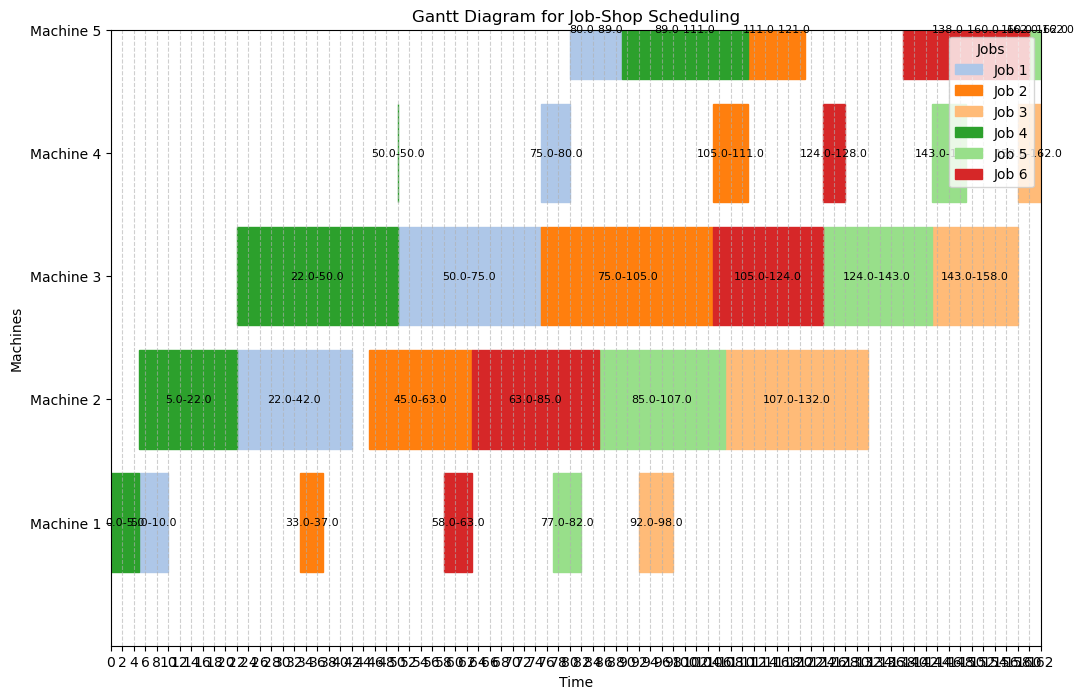

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Berechnete Start- und Endzeiten für das Gantt-Diagramm sammeln
tasks = []
max_time = 0  # Zum Festlegen der maximalen Zeit für die X-Achse
for j in range(n):
    for i in range(m):
        start_time = x[j][i].x
        duration = times[j][i]
        end_time = start_time + duration
        tasks.append((j+1, i+1, start_time, end_time))
        max_time = max(max_time, end_time)  # Höchste Endzeit bestimmen

# Farben und Labels für Maschinen
colors = plt.cm.tab20.colors  # Farbpalette für unterschiedliche Maschinen
machine_labels = [f"Machine {i+1}" for i in range(m)]

# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(12, 8))

# Aufgaben auf dem Gantt-Diagramm darstellen
for task in tasks:
    job_id, machine_id, start, end = task
    ax.add_patch(mpatches.Rectangle((start, machine_id - 0.4),  # x, y
                                    end - start,  # Breite
                                    0.8,  # Höhe
                                    color=colors[job_id % len(colors)],
                                    edgecolor='black',
                                    label=f"Job {job_id}" if machine_id == 1 else ""))
    
    # Start- und Endzeit auf den Balken anzeigen
    ax.text(start + (end - start) / 2, machine_id, f"{start}-{end}", 
            ha='center', va='center', color='black', fontsize=8)

# Achsenbeschriftung und Formatierung
ax.set_yticks(range(1, m+1))
ax.set_yticklabels(machine_labels)
ax.set_xticks(range(0, int(max_time) + 1, 2))  # Schrittweite für die Zeitachse anpassen
ax.set_xlim(0, max_time)
ax.set_xlabel("Time")
ax.set_ylabel("Machines")
ax.set_title("Gantt Diagram for Job-Shop Scheduling")

# Doppelte Labels in der Legende entfernen
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="upper right", title="Jobs")

plt.grid(axis='x', linestyle='--', alpha=0.6)  # Hilfslinien für die Zeitachse
plt.show()


In [ ]:
from itertools import product
from mip import Model, BINARY

n = 5
m = 4

# Bearbeitungsdauern für jeden Auftrag auf jeder Maschine
times = [[5, 20, 25, 5],
     [4, 18, 30, 6],
     [6, 25, 15, 4],
     [5, 17, 28, 5],
     [5, 22, 19, 6]]

# Maschinenreihenfolge (alle Aufträge haben die gleiche Reihenfolge)
machines = [
    [0, 1, 2, 3],  # Auftrag 1
    [0, 1, 2, 3],  # Auftrag 2
    [0, 1, 2, 3],  # Auftrag 3
    [0, 1, 2, 3],  # Auftrag 4
    [0, 1, 2, 3]]

M = sum(times[i][j] for i in range(n) for j in range(m))

model = Model('JSSP')

c = model.add_var(name="C")
x = [[model.add_var(name='x({},{})'.format(j+1, i+1))
      for i in range(m)] for j in range(n)]
y = [[[model.add_var(var_type=BINARY, name='y({},{},{})'.format(j+1, k+1, i+1))
       for i in range(m)] for k in range(n)] for j in range(n)]

model = Model('JSSP')

c = model.add_var(name="C")
x = [[model.add_var(name='x({},{})'.format(j+1, i+1))
      for i in range(m)] for j in range(n)]
y = [[[model.add_var(var_type=BINARY, name='y({},{},{})'.format(j+1, k+1, i+1))
       for i in range(m)] for k in range(n)] for j in range(n)]

model.objective = c

for (j, i) in product(range(n), range(1, m)):
    model += x[j][machines[j][i]] - x[j][machines[j][i-1]] >= \
        times[j][machines[j][i-1]]

for (j, k) in product(range(n), range(n)):
    if k != j:
        for i in range(m):
            model += x[j][i] - x[k][i] + M*y[j][k][i] >= times[k][i]
            model += -x[j][i] + x[k][i] - M*y[j][k][i] >= times[j][i] - M

for j in range(n):
    model += c - x[j][machines[j][m - 1]] >= times[j][machines[j][m - 1]]

# Bedingungen hinzufügen
for j in range(n):
    # Bedingung für die Maschine 4 (Index 3)
    if m > 3:  # Überprüfen, ob es mindestens 4 Maschinen gibt
        model += x[j][3] - x[j][2] == times[j][2]  # Bedingung nur für die vierte Maschine
        

# Bedingungen hinzufügen
for j in range(n):
    # Bedingung für die Maschine 1 (Index 0) und Maschine 3 (Index 2)
    model += x[j][machines[j][2]] - x[j][machines[j][0]] <= 20 + times[j][machines[j][1]] + + times[j][machines[j][0]] # Maschine 1 muss 30 Zeit vor Maschine 3 freigegeben werden


model.optimize()

print("Completion time: ", c.x)
for (j, i) in product(range(n), range(m)):
    print("task %d starts on machine %d at time %g " % (j+1, i+1, x[j][i].x))

IndexError: list index out of range

In [ ]:
from itertools import product
from mip import Model, BINARY

n = 6
m = 5

# Bearbeitungsdauern für jeden Auftrag auf jeder Maschine
times = [[5, 20, 25, 5, 9],
     [4, 18, 30, 6, 10],
     [6, 25, 15, 4, 0],
     [5, 17, 28, 0, 22],
     [5, 22, 19, 6, 2],
     [5, 22, 19, 4, 22]]

# Maschinenreihenfolge (alle Aufträge haben die gleiche Reihenfolge)
machines = [
    [0, 1, 2, 3, 4],  # Auftrag 1
    [0, 1, 2, 3, 4],  # Auftrag 2
    [0, 1, 2, 3, 4],  # Auftrag 3
    [0, 1, 2, 3, 4],  # Auftrag 4
    [0, 1, 2, 3, 4], 
    [0, 1, 2, 3, 4]]

M = sum(times[i][j] for i in range(n) for j in range(m))

model = Model('JSSP')

c = model.add_var(name="C")
x = [[model.add_var(name='x({},{})'.format(j+1, i+1))
      for i in range(m)] for j in range(n)]
y = [[[model.add_var(var_type=BINARY, name='y({},{},{})'.format(j+1, k+1, i+1))
       for i in range(m)] for k in range(n)] for j in range(n)]

model.objective = c

for (j, i) in product(range(n), range(1, m)):
    model += x[j][machines[j][i]] - x[j][machines[j][i-1]] >= \
        times[j][machines[j][i-1]]

for (j, k) in product(range(n), range(n)):
    if k != j:
        for i in range(m):
            model += x[j][i] - x[k][i] + M*y[j][k][i] >= times[k][i]
            model += -x[j][i] + x[k][i] - M*y[j][k][i] >= times[j][i] - M

for j in range(n):
    model += c - x[j][machines[j][m - 1]] >= times[j][machines[j][m - 1]]

# Bedingungen hinzufügen
for j in range(n):
    # Bedingung für die Maschine 4 (Index 3)
    if m > 3:  # Überprüfen, ob es mindestens 4 Maschinen gibt
        model += x[j][3] - x[j][2] == times[j][2]  # Bedingung nur für die vierte Maschine
        model += x[j][3] - x[j][2] == times[j][2]

# Bedingungen hinzufügen
for j in range(n):
    # Bedingung für die Maschine 1 (Index 0) und Maschine 3 (Index 2)
    model += x[j][machines[j][2]] - x[j][machines[j][0]] <= 20 + times[j][machines[j][1]] + + times[j][machines[j][0]] # Maschine 1 muss 30 Zeit vor Maschine 3 freigegeben werden


model.optimize()

print("Completion time: ", c.x)
for (j, i) in product(range(n), range(m)):
    print("task %d starts on machine %d at time %g " % (j+1, i+1, x[j][i].x))

Completion time:  162.0
task 1 starts on machine 1 at time 5 
task 1 starts on machine 2 at time 22 
task 1 starts on machine 3 at time 50 
task 1 starts on machine 4 at time 75 
task 1 starts on machine 5 at time 80 
task 2 starts on machine 1 at time 33 
task 2 starts on machine 2 at time 45 
task 2 starts on machine 3 at time 75 
task 2 starts on machine 4 at time 105 
task 2 starts on machine 5 at time 111 
task 3 starts on machine 1 at time 92 
task 3 starts on machine 2 at time 107 
task 3 starts on machine 3 at time 143 
task 3 starts on machine 4 at time 158 
task 3 starts on machine 5 at time 162 
task 4 starts on machine 1 at time 0 
task 4 starts on machine 2 at time 5 
task 4 starts on machine 3 at time 22 
task 4 starts on machine 4 at time 50 
task 4 starts on machine 5 at time 89 
task 5 starts on machine 1 at time 77 
task 5 starts on machine 2 at time 85 
task 5 starts on machine 3 at time 124 
task 5 starts on machine 4 at time 143 
task 5 starts on machine 5 at time 